<a href="https://colab.research.google.com/github/trixing/tune/blob/master/Insulin_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrals (should be 1.0) 0.9990705148487962 1.0 0.9998953406907598


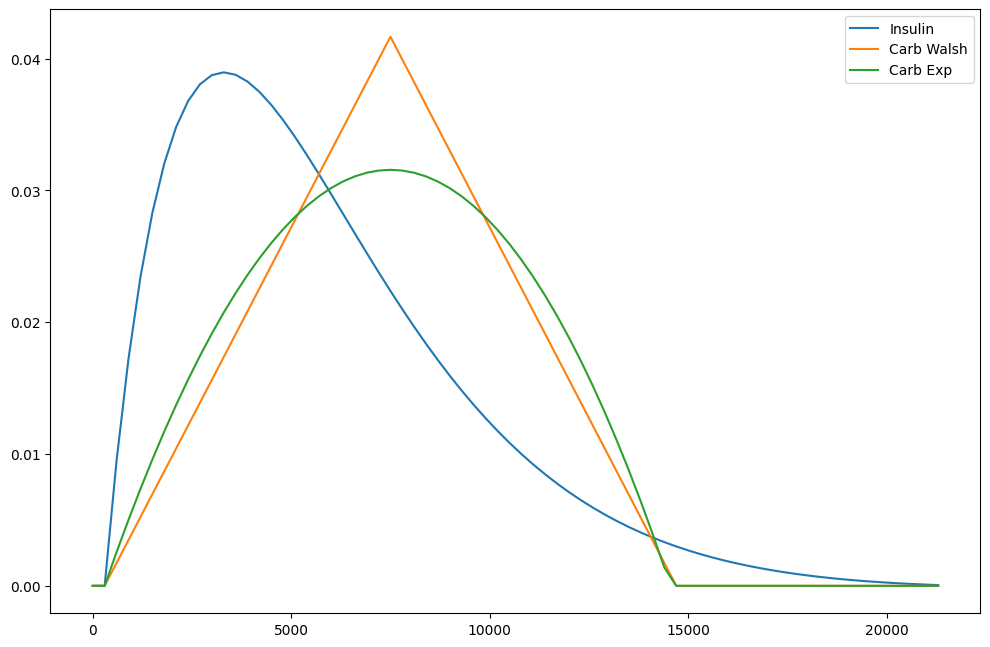

In [ ]:
import numpy as np
from math import exp,pow
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
import scipy.optimize
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

model_step = 5 * 60

insulin_delay = 5.0 * 60 / model_step
insulin_peak = 50.0 * 60 / model_step
insulin_duration = 6.0 * 60 * 60 / model_step

carb_delay = 5.0 * 60 / model_step
carb_duration = 240 * 60 / model_step

def walshca(t, tdel, tdur):
    """Walsh carb absorption curves with provided delays and duration."""
    return ((t >= tdel) & (t <= tdel + tdur / 2)) * (
        4 * (t - tdel) / np.square(tdur)
    ) + ((t > tdel + tdur / 2) & (t <= tdel + tdur)) * (
        4 / tdur * (1 - (t - tdel) / tdur)
    )


def expia1(t, delay, tp, td):
    """Exponential insulin curve, parameterized by peak and duration,
    due to Dragan Maksimovic (@dm61).
    Worked by Pete (@ps2) in the notebook
        https://github.com/ps2/LoopIOB/blob/master/ScalableExp.ipynb
    Reworked here to be vectorized by numpy.
    """
    t = shift(t, delay)
    tau = tp * (1 - tp / td) / (1 - 2 * tp / td)
    a = 2 * (tau / td)
    S = 1 / (1 - a + (1 + a) * np.exp(-td / tau))
    return np.maximum(0.0, (S / np.power(tau, 2)) * t * (1 - t / td) * np.exp(-t / tau))

t = np.array(range(0, int(insulin_duration), 1))

insulin_coeff = expia1(t, insulin_delay, insulin_peak, insulin_duration)
carb_coeff = walshca(t, carb_delay, carb_duration)
carb_exp_coeff = expia1(t, carb_delay, carb_duration/2, carb_duration*0.99)
print("Integrals (should be 1.0)", np.trapz(insulin_coeff), np.trapz(carb_coeff), np.trapz(carb_exp_coeff))
#print(t * model_step, r)

plt.figure()
plt.plot(t * model_step, insulin_coeff)
plt.plot(t * model_step, carb_coeff)
plt.plot(t * model_step, carb_exp_coeff)
plt.legend(('Insulin', 'Carb Walsh', 'Carb Exp'))

In [ ]:
def model(inputs, *params):
  isf, basal_hourly, cr = params
  num_steps = len(inputs['insulin'][0])
  # print(len(inputs['hours']), num_steps)
  boundary = max(len(carb_coeff), len(insulin_coeff))
  output_timeline = np.zeros(num_steps + boundary)
  # todo use input['hours'] to pick the isf/basal/cr factor
  # Hardcoded 5 minute bucket size, boo.
  sim_basal_body = np.array([basal_hourly/12 for _ in inputs['hours']])
  for insulin in inputs['insulin'] + [sim_basal_body/-1]:
    assert len(insulin) == num_steps
    for i, b in enumerate(insulin):
      ic = b * insulin_coeff
      for j, eff in enumerate(ic):
        output_timeline[i + j] -= eff * isf

  carb_coeff_local = walshca(t, carb_delay, 180 * 60 / model_step)

  for carbs in inputs.get('carbs', []):
    assert len(carbs) == num_steps

    for i, b in enumerate(carbs):
      ic = b * carb_coeff_local
      for j, eff in enumerate(ic):
        output_timeline[i + j] += eff * isf / cr
    
  # Do not return the trailing edge to have the same length as the input
  return output_timeline[:-boundary]

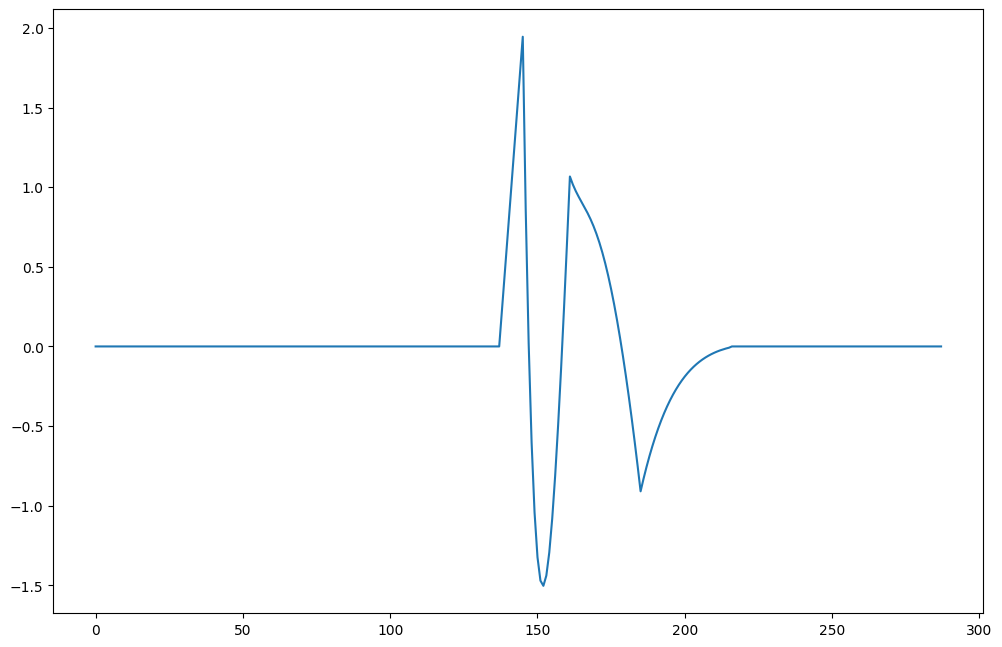

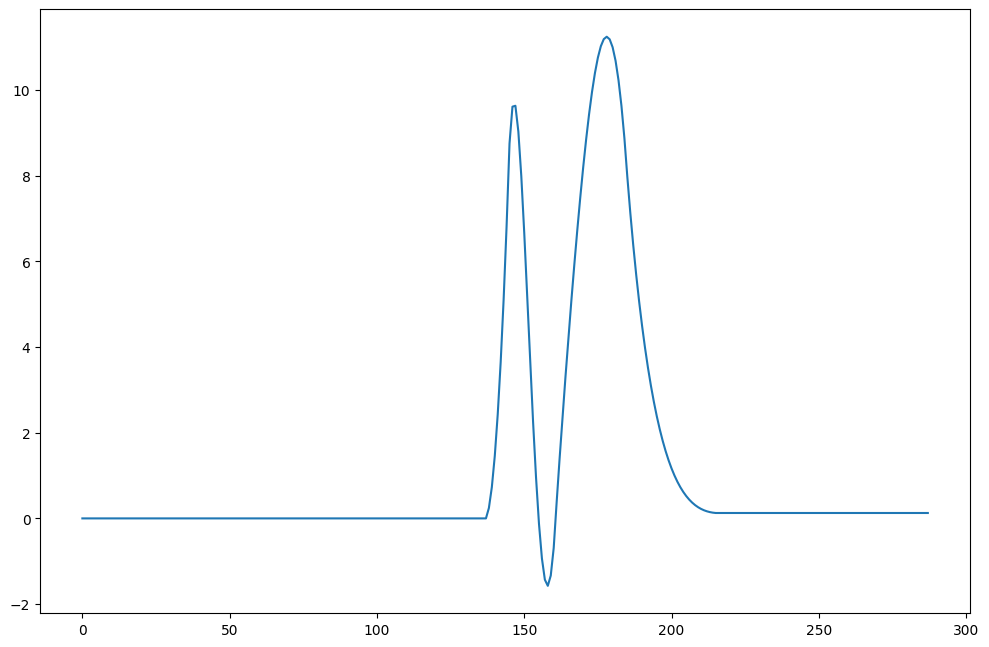

In [ ]:
num_steps = int(86400/model_step)
hours = np.array([int((step * model_step % 86400) / 3600) for step in range(num_steps)])

# Body (ie. what we want to get out of the simulation in the end)
sim_isf_body = 140.0
sim_cr_body = 9.0
sim_basal_rate_body = 0.7 # * np.ones(num_steps) # increases glucose

# Known Inputs
sim_basal_pump = (0.7 / 12) * np.ones(num_steps) # decreases glucose
sim_carbs =  np.zeros(num_steps) # increases glucose 
sim_carbs[int(num_steps/2)-8] = 9.0
#sim_carbs[int(2*num_steps/3)] = 5.0
sim_insulin = np.zeros(num_steps) # decreases glucose
sim_insulin[int(num_steps/2)] = 1
#sim_insulin[int(num_steps/4)] = 4



sim_glucose = model({'insulin': [sim_basal_pump, sim_insulin],
                     'carbs': [sim_carbs],
                     'hours': hours},
                    sim_isf_body, sim_basal_rate_body, sim_cr_body)

plt.figure()
plt.plot(sim_glucose)
plt.figure()
plt.plot(np.cumsum(sim_glucose))

In [ ]:
scipy.optimize.show_options('minimize', 'SLSQP')

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.


In [ ]:
# print(np.array([1,2])**2)
def loss(params, delta_glucose_target, inputs):
  isf, basal, cr = params
  sim_approx = model(inputs, isf, basal, cr)
  boundary = max(len(carb_coeff), len(insulin_coeff))
  # Ignore the start of data as we don't have the effects from history.
  diff = (sim_approx - delta_glucose_target)[boundary:]
  error = np.sum(diff**2)
  # print(basal, error)
  quantile = 0.5 # from tune model
  #error = np.mean(np.maximum(quantile * diff, (quantile - 1.0) * diff))

  return error


[1 4]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: OptimizeWarning: Unknown solver options: gtol, eps, maxfun


 final_simplex: (array([[415.05812456,   0.70076241,  10.09590363],
       [415.05812456,   0.70076241,  10.09590363],
       [415.05812456,   0.70076241,  10.09590363],
       [415.05812456,   0.70076241,  10.09590363]]), array([5201.70346387, 5201.70346387, 5201.70346387, 5201.70346387]))
           fun: 5201.703463869828
       message: 'Optimization terminated successfully.'
          nfev: 330
           nit: 159
        status: 0
       success: True
             x: array([415.05812456,   0.70076241,  10.09590363])


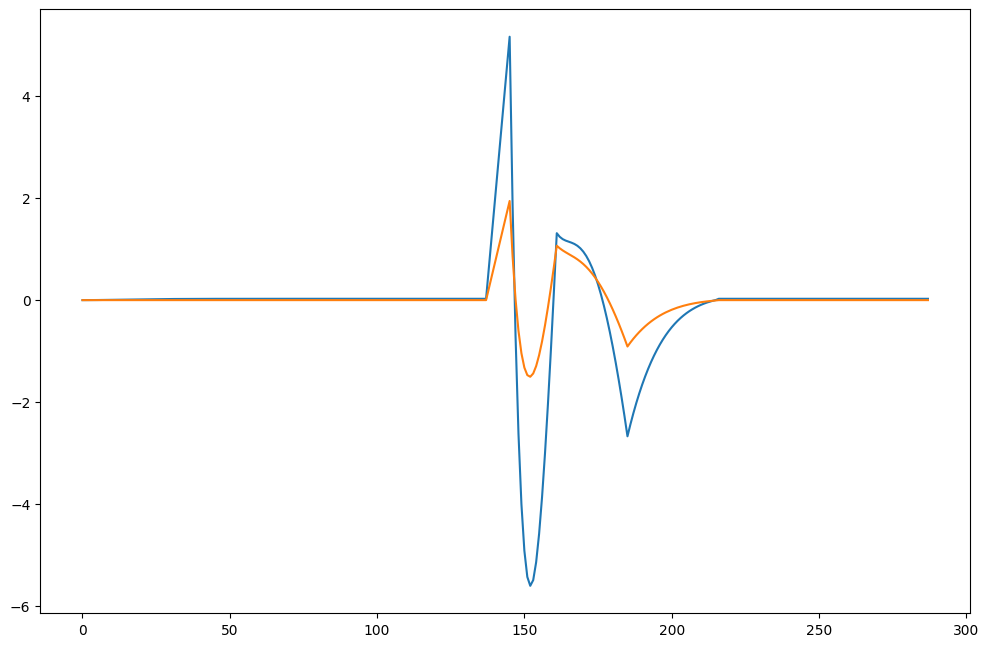

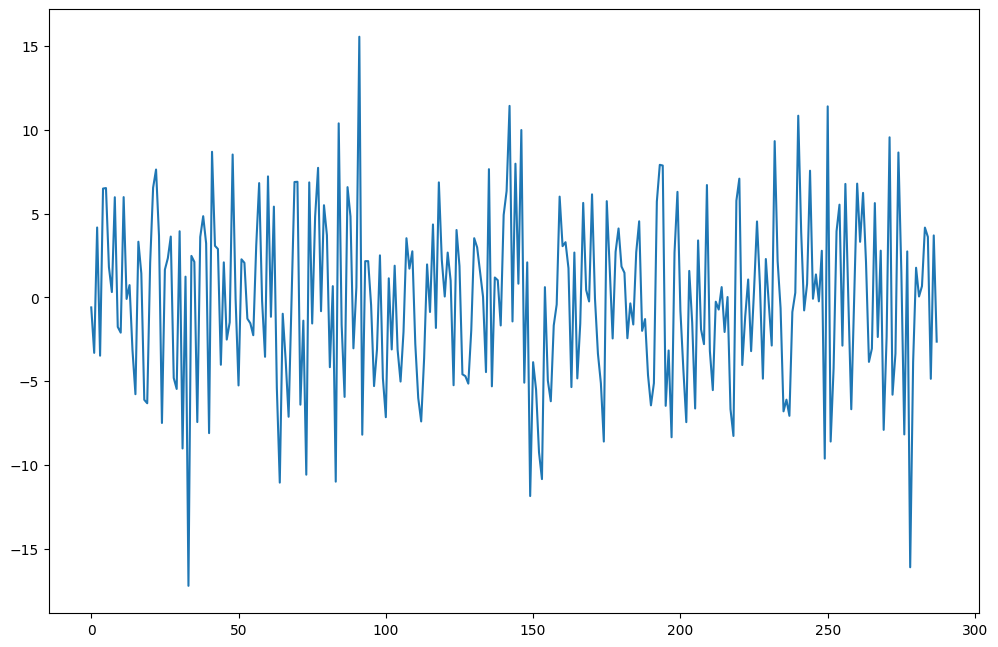

In [ ]:
# Unit test for the optimizer, should roughly
# discover the parameters above, even with noise.
import scipy.optimize

assert any(sim_glucose)
input_glucose_delta = sim_glucose + np.random.normal(0, 5, sim_glucose.shape)


# Initial isf,  basal, carb ratio,
inputs = {'insulin': [sim_basal_pump, sim_insulin], 'carbs': [sim_carbs],
                      'hours': hours}
initial_params = [100, 1, 10]
bounds = ((50, 200), (0.1, 2.0), (1.0, 20.0))
opt = scipy.optimize.minimize(
    loss, np.array(initial_params),
    args=(input_glucose_delta, inputs),
    #method='L-BFGS-B', tol=1e-9, bounds=bounds,
        method='Nelder-Mead', tol=1e-9, bounds=bounds,

    options={'ftol': 1e-10, 'gtol': 1e-10, 'eps': 1e-10, 
             'maxfun': 40000, 'maxiter': 40000}
    )
print(opt)
res = model(inputs, opt.x[0], opt.x[1], opt.x[2])
plt.figure()
plt.plot(res)
plt.plot(sim_glucose)
plt.figure()
plt.plot(input_glucose_delta)

In [ ]:
import json
data = json.loads(open("new3.json").read())

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8]
[ 0.          0.         -0.3         0.          0.          0.
  0.          0.          0.          0.         -0.775      -0.775
 -0.775      -0.775      -1.34591667 -0.775      -0.775       0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.775      -0.58383333  0.         -0.56058333
  0.         -0.775      -0.76208333  0.          0.          0.
  0.          0.          0.         -0.3       ]
[ 0.5         0.5         0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5
  0.5         0.10133333  0.1         0.025       0.025       0.025
  0.025       0.025       0.025       0.025       0.1         0.025
  0.025      -0.057       0.6         0.7         0.7         0.7       ]
[0.1 0.  0.  3.4 0.  0.  0.  0.  0.  0.4 4.

<Figure size 1200x800 with 0 Axes>

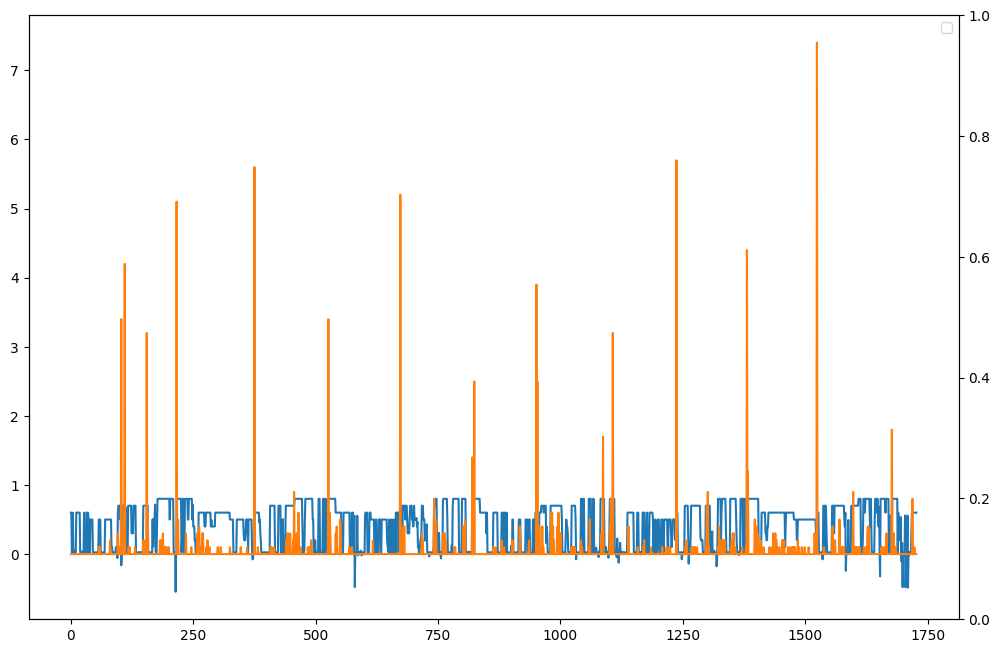

In [ ]:
total_basal =  (
                      np.array(data['prog_basal']) +
                      np.array(data['basal']))
#total_carbs = np.sum()
print(np.array(data['prog_basal'])[200:240]*12)
print(np.array(data['basal'])[200:240]*12)
print(total_basal[70:100]*12)
print(np.array(data['bolus'])[100:120])
i = 0
j = 12*24*6
plt.figure()
fig, ax = plt.subplots() 
ax.plot(12*total_basal[i:j])
ax.plot(np.array(data['bolus'])[i:j])
legend = ['basal', 'bolus']
ax2 = ax.twinx()
for absorption, carbs in data['carbs'].items(): 
  #ax2.plot(carbs[i:j])
  legend.append('carbs ' + absorption)
plt.legend(legend)

[ 0.         -1.         -1.00664452 ... -2.94333333 -3.00946488
 -3.9346215 ]
2015 2029


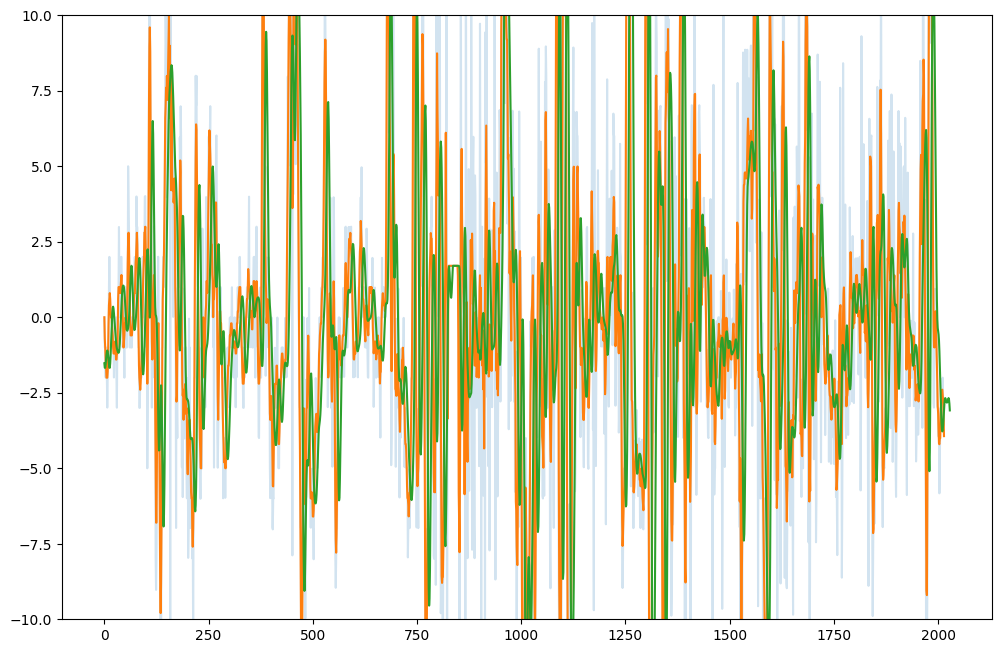

In [ ]:

# print(data)
inputs = {'insulin': [
                      np.array(data['bolus']), 
                      np.array(data['prog_basal']),
                      np.array(data['basal'])
                      ], 
          'carbs': [np.array(c) for a, c in data['carbs'].items()]
                    ,
          'hours': np.array(
              data['hours']
            )}
glucose = np.array(data['glucose'])

#g = smooth(g, window_len=13, window='flat')
glucose_delta = np.concatenate((np.zeros(1), np.diff(glucose) ))
print(glucose_delta)
input = glucose_delta.copy()
for i, g in enumerate(glucose_delta):
  if i > 1 and i < (len(glucose_delta) - 2):
    glucose_delta[i] =  input[i-2]*0.2 + input[i-1]*0.2 + input[i]*0.2 + input[i+1]*0.2 + input[i+2]*0.2
  elif i > 0 and i < (len(glucose_delta) - 1):
    glucose_delta[i] = input[i-1]*0.3 + input[i]*0.4 + input[i+1]*0.3
  glucose_delta[i] = min(glucose_delta[i], 20)
  glucose_delta[i] = max(glucose_delta[i], -20)

s = smooth(input, window_len=15)
plt.figure()
plt.plot(input, alpha=0.2)
plt.plot(glucose_delta)
plt.plot(s)
# plt.legend(('Smoothed', 'Glucose Delta'))
plt.ylim(-10, 10)

print(len(input), len(s))
glucose_delta = s[0:len(input)]
#print(len(glucose_delta))

In [ ]:

initial_params = [100, 1, 10]
bounds = ((50, 200), (0.1, 2.0), (1.0, 20.0))
opt = scipy.optimize.minimize(
    loss, np.array(initial_params),
    args=(glucose_delta, inputs),
    method='Nelder-Mead', 
    #method='L-BFGS-B',
    tol=1e-9, bounds=bounds,
    options={'ftol': 1e-10, 'gtol': 1e-10, 'eps': 1e-10, 
             'maxfun': 40000, 'maxiter': 40000}
    )
print(opt)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: gtol, eps, maxfun
  # This is added back by InteractiveShellApp.init_path()


 final_simplex: (array([[-1.36982147e+01,  1.16954183e+00,  4.01085098e+13],
       [-1.36982147e+01,  1.16954183e+00,  4.01085098e+13],
       [-1.36982147e+01,  1.16954183e+00,  4.01085098e+13],
       [-1.36982147e+01,  1.16954183e+00,  4.01085098e+13]]), array([35950.9342201, 35950.9342201, 35950.9342201, 35950.9342201]))
           fun: 35950.93422010145
       message: 'Optimization terminated successfully.'
          nfev: 924
           nit: 450
        status: 0
       success: True
             x: array([-1.36982147e+01,  1.16954183e+00,  4.01085098e+13])


Loss to ideal 115272.37754502968
ISF / Basal / CR [50.          0.78508922  9.33252263]
Loss to trained 39536.16456005373
Loss to trained x10 787886.625566077


(-20.0, 20.0)

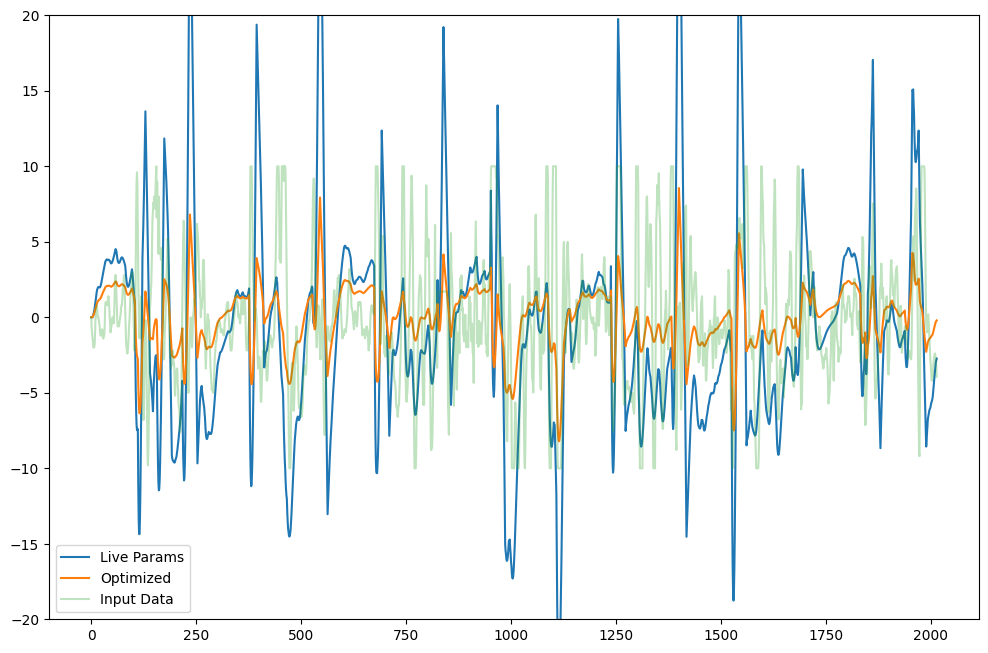

In [ ]:

res = model(inputs, 140, 0.6, 7)
print("Loss to ideal", loss((140, 0.6, 7), glucose_delta, inputs))

print("ISF / Basal / CR", opt.x)
res2 = model(inputs, opt.x[0], opt.x[1], opt.x[2])
print("Loss to trained", loss((opt.x[0], opt.x[1], opt.x[2]), glucose_delta, inputs))
print("Loss to trained x10", loss((10*opt.x[0], opt.x[1], opt.x[2]), glucose_delta, inputs))


plt.figure()
plt.plot(res)
plt.plot(res2)
plt.plot(glucose_delta, alpha=0.3)
plt.legend(('Live Params', 'Optimized', 'Input Data'))
plt.ylim(-20, 20)


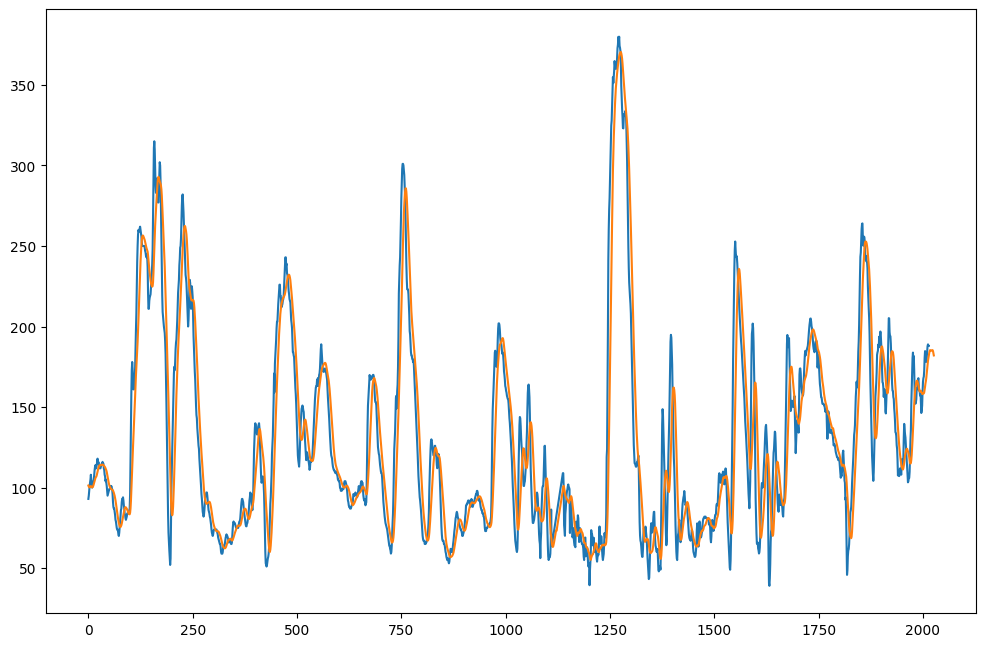

In [ ]:


g = np.array(data['glucose'])
plt.figure()
plt.plot(g)
plt.plot(smooth(g, window_len=13, window='hamming'))
